# Matrix Factorization

[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)

Matrix Factorizaation solves the following optimiation problem:

$$
   \min_{\substack{
      \mathbf{P} \in \mathbb{R}^{n \times r}, 
      \mathbf{a} \in \mathbb{R}^n \\
      \mathbf{Q} \in \mathbb{R}^{m \times r}, 
      \mathbf{b} \in \mathbb{R}^m
   }} 
   \left[
      \sum_{(u,i)\in \Omega} C \cdot \phi(\mathbf{p}_u^\top \mathbf{q}_i + a_u + b_i) 
   \right]  
   + 
   \left[ 
      \frac{\rho}{n}\sum_{u=1}^n(\|\mathbf{p}_u\|_2^2 + a_u^2) 
      + \frac{1-\rho}{m}\sum_{i=1}^m(\|\mathbf{q}_i\|_2^2 + b_i^2) 
   \right]
$$

where

- $\phi(\cdot)$
  gives a loss value corresponding to the ground truth.
  
- $\Omega$
  is a user-item collection that records all training data

- $n$ is number of users, $m$ is number of items

- $C$ is regularization parameter, $\rho$ balances regularization strength between user and item

- $\mathbf{p}_u$ and $a_u$
  are latent vector and individual bias of u-th user. Specifically, $\mathbf{p}_u$ is the u-th row of $\mathbf{P}$, and $a_u$ is the u-th element of $\mathbf{a}$
  
- $\mathbf{q}_i$ and $b_i$
  are latent vector and individual bias of i-th item. Specifically, $\mathbf{q}_i$ is the i-th row of $\mathbf{Q}$, and $b_i$ is the i-th element of $\mathbf{b}$

<br>
<br>

Or you can choose to use an unbiased version of this algorithm, which simply optimizes:

$$
   \min_{\substack{
      \mathbf{P} \in \mathbb{R}^{n \times r}\\
      \mathbf{Q} \in \mathbb{R}^{m \times r}
   }} 
   \left[
      \sum_{(u,i)\in \Omega} C \cdot \phi(\mathbf{p}_u^\top \mathbf{q}_i) 
   \right]  
   + 
   \left[ 
      \frac{\rho}{n}\sum_{u=1}^n\|\mathbf{p}_u\|_2^2 
      + \frac{1-\rho}{m}\sum_{i=1}^m\|\mathbf{q}_i\|_2^2 
   \right]
$$



In [1]:
## simulate data
import numpy as np
from rehline import plqMF_Ridge, make_ratings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

user_num, item_num = 1200, 4000 
ratings = make_ratings(n_users=user_num, n_items=item_num, n_interactions=50000, seed=42) 
X_train, X_test, y_train, y_test = train_test_split(ratings['X'], ratings['y'], test_size=0.3, random_state=42)

## Classification Task

For this task we choose **hinge square loss** as $\phi(\cdot)$ and `biased=False`, prediction will be made by:

$$
\hat{y}_{ui} = \mathbf{p}_u^\top \mathbf{q}_i
$$

**Make claasification data**

In [2]:
y_train_bin = np.where(y_train > 3.0, 1, -1)
y_test_bin = np.where(y_test > 3.0, 1, -1)

**Train the model and monitor training process**

In [3]:
## hinge square loss model
clf = plqMF_Ridge(C=0.0001, rank=6, verbose=1,
                  biased=False, loss={'name': 'hinge square'},
                  n_users=user_num, n_items=item_num)
clf.fit(X_train, y_train_bin)

y_pred = clf.decision_function(X_test) 

Iteration    Average Loss(hinge square) Objective Function  
1            0.853983             3.264175            
2            0.378807             2.379666            
3            0.257713             2.078474            
4            0.194505             1.868640            
5            0.169989             1.769799            
6            0.161334             1.734938            
7            0.156685             1.720333            
8            0.153585             1.712486            
9            0.151342             1.707457            
10           0.149640             1.703883            


**Visualize the confusion matrix**

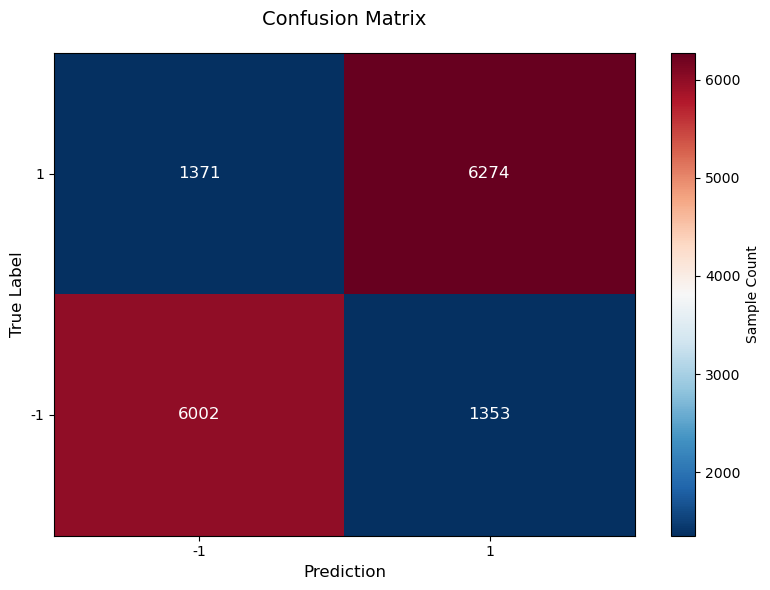

In [4]:
y_pred_bin = np.where(y_pred > 0, 1, -1)

## visualize the confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin, labels=[-1, 1])
plt.figure(figsize=(8, 6))
mesh = plt.pcolormesh(cm, cmap='RdBu_r')

for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > 50 else 'black'
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), 
                 ha='center', va='center', fontsize=12, color=text_color)

cbar = plt.colorbar(mesh)
cbar.set_label('Sample Count', fontsize=10)
plt.xticks(np.arange(2) + 0.5, [-1, 1])
plt.yticks(np.arange(2) + 0.5, [-1, 1])
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Regression Task

For this task we choose **absolute loss** as $\phi(\cdot)$ and `biased=True`, prediction will be made by:

$$
\hat{y}_{ui} = \mathbf{p}_u^\top \mathbf{q}_i + a_u + b_i
$$

**Train the model**

In [5]:
## baseline model
y_pred_baseline = np.mean(y_train)


## absolute loss model
model = plqMF_Ridge(C=0.0001, rank=6, 
                    biased=True, loss={'name': 'mae'},
                    n_users=user_num, n_items=item_num)
model.fit(X_train, y_train)

y_pred = model.decision_function(X_test) 


## comparison
models = [
    ("Baseline", np.full(len(y_test), y_pred_baseline)),
    ("Absolute Loss MF", y_pred)
]

print("=" * 40)
print(f"{'Model':<20} {'MAE':<8} {'RMSE':<8}")
print("-" * 40)

for name, pred in models:
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name:<20} {mae:<8.4f} {rmse:<8.4f}")

print("=" * 40)

Model                MAE      RMSE    
----------------------------------------
Baseline             0.5946   0.7396  
Absolute Loss MF     0.2671   0.3390  


**Check the result**

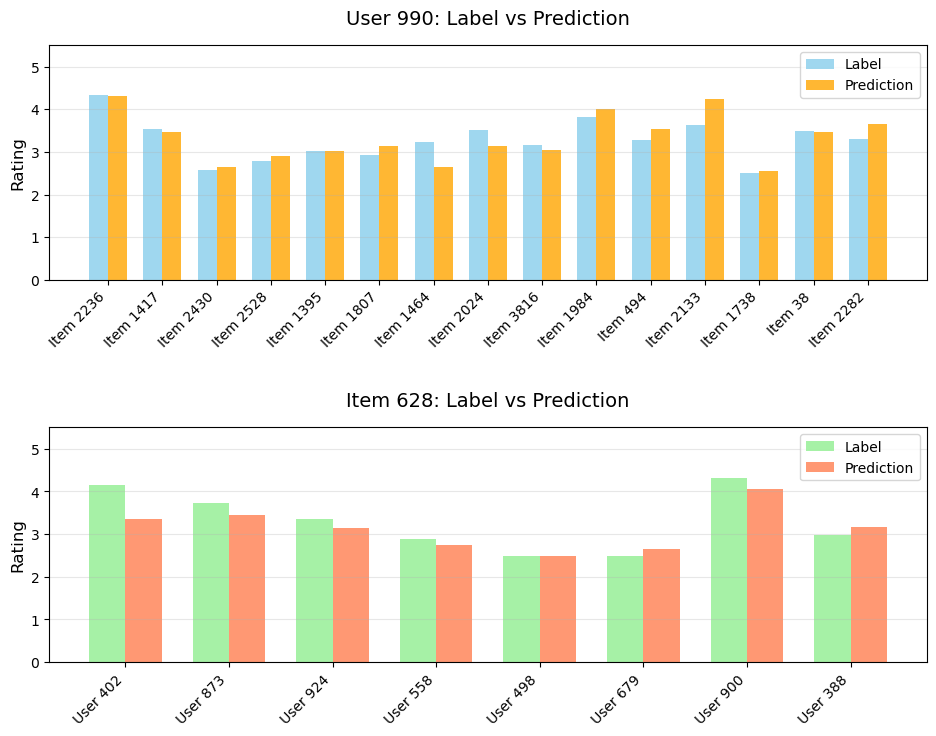

In [6]:
fig, (ax_user, ax_item) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))  


## users in test set
test_users = np.unique(X_test[:, 0])
## ensure that user with at least 5 items are selected (avoid cold start)
valid_users = [u for u in test_users if len(X_test[X_test[:, 0]==u]) >= 5]
## randomly select a user from test set
selected_user = np.random.choice(valid_users, size=1)[0]  

## select interaction data from test set
user_mask = (X_test[:, 0] == selected_user)
user_items = X_test[user_mask, 1]
user_true = y_test[user_mask]
user_pred = y_pred[user_mask]

x_user = np.arange(len(user_items))
width = 0.35
ax_user.bar(x_user - width/2, user_true, width, label='Label', color='skyblue', alpha=0.8)
ax_user.bar(x_user + width/2, user_pred, width, label='Prediction', color='orange', alpha=0.8)
ax_user.set_title(f'User {selected_user}: Label vs Prediction', fontsize=14, pad=15)
ax_user.set_xticks(x_user)
ax_user.set_xticklabels([f'Item {item}' for item in user_items], rotation=45, ha='right')
ax_user.set_ylim(0, 5.5)
ax_user.set_ylabel('Rating', fontsize=12)
ax_user.legend(fontsize=10)
ax_user.grid(axis='y', alpha=0.3)


## items in test set
test_items = np.unique(X_test[:, 1])
## ensure that item with at least 5 users are selected (avoid cold start)
valid_items = [i for i in test_items if len(X_test[X_test[:, 1]==i]) >= 5]
## randomly select an item from test set
selected_item = np.random.choice(valid_items, size=1)[0]  

# select interaction data from test set
item_mask = (X_test[:, 1] == selected_item)
item_users = X_test[item_mask, 0]
item_true = y_test[item_mask]
item_pred = y_pred[item_mask]

x_item = np.arange(len(item_users))
ax_item.bar(x_item - width/2, item_true, width, label='Label', color='lightgreen', alpha=0.8)
ax_item.bar(x_item + width/2, item_pred, width, label='Prediction', color='coral', alpha=0.8)
ax_item.set_title(f'Item {selected_item}: Label vs Prediction', fontsize=14, pad=15)
ax_item.set_xticks(x_item)
ax_item.set_xticklabels([f'User {user}' for user in item_users], rotation=45, ha='right')
ax_item.set_ylim(0, 5.5)
ax_item.set_ylabel('Rating', fontsize=12)
ax_item.legend(fontsize=10)
ax_item.grid(axis='y', alpha=0.3)


plt.tight_layout(pad=3.0)  
plt.show()